In [67]:
from IPython.core.debugger import set_trace

from glob import glob
from sklearn.cluster import KMeans
from tqdm import tqdm_notebook as tqdm

import pandas as pd
import numpy as np
import cv2
import matplotlib.pyplot as plt

### I am going to use K-means clustering on the data that consist of HSV colorspace values of the skin color that has been extracted from faces on the previous step

In [71]:
# Load DataFrame 
path = '/home/nikolaytv/workspace/datasets/UTKFace/'
df = pd.read_pickle(path + '/UTKFace.pkl')
df = df.dropna().reset_index(drop=True)

# Add columns in df for each channel
df['H'] = None
df['S'] = None
df['V'] = None

for i in tqdm(df.index[:]):
    H, S, V = df.at[i, 'hsv_color']
    df.at[i, 'H'] = H
    df.at[i, 'S'] = S
    df.at[i, 'V'] = V
    
print(df.shape) 
df.head()


(21915, 9)


path  gender  age  etnicity  \
0  UTKFace/32_0_1_20170113134657712.jpg.chip.jpg       0   32         1   
1  UTKFace/62_0_0_20170111204633236.jpg.chip.jpg       0   62         0   
2  UTKFace/40_0_0_20170117152243349.jpg.chip.jpg       0   40         0   
3  UTKFace/28_0_4_20170117180230348.jpg.chip.jpg       0   28         4   
4   UTKFace/1_0_2_20161219222046607.jpg.chip.jpg       0    1         2   

        hsv_color        rgb_color   H    S    V  
0   [7, 101, 125]    [125, 87, 75]   7  101  125  
1   [9, 113, 146]   [146, 101, 81]   9  113  146  
2  [10, 117, 198]  [198, 137, 107]  10  117  198  
3  [16, 150, 214]   [214, 155, 88]  16  150  214  
4   [7, 152, 137]    [137, 74, 55]   7  152  137

In [72]:
data = df[['H', 'S', 'V']].values
print(data.shape)
data

(21915, 3)


array([[7, 101, 125],
       [9, 113, 146],
       [10, 117, 198],
       ...,
       [7, 82, 193],
       [8, 114, 192],
       [9, 54, 188]], dtype=object)

### Apply Elbow method to find optimal number of clusters


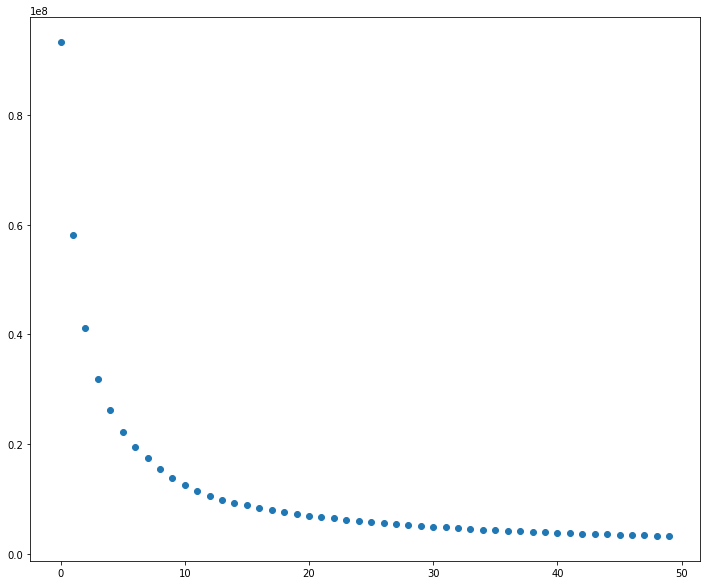

In [4]:
n = 50
ppk = np.zeros(n)
for i in tqdm(range(n)):
    kmeans = KMeans(n_clusters = i+1, n_init = 10, n_jobs=-1)
    kmeans.fit(data)
    ppk[i] = kmeans.inertia_

plt.figure(figsize = (12, 10))
plt.scatter(np.arange(n), ppk)
plt.show()

### After experimenting number of times and looking on the Elbow-plot, 
### I arbitrary chose optimal number of clusters to be 12

In [43]:
kmeans = KMeans(n_clusters = 12, n_init = 10, n_jobs=-1)
kmeans.fit(data)
df['y_pred'] = kmeans.labels_

# Add cluster information to df
clt0 = df[df.y_pred == 0]
clt1 = df[df.y_pred == 1]
clt2 = df[df.y_pred == 2]
clt3 = df[df.y_pred == 3]
clt4 = df[df.y_pred == 4]
clt5 = df[df.y_pred == 5]
clt6 = df[df.y_pred == 6]
clt7 = df[df.y_pred == 7]
clt8 = df[df.y_pred == 8]
clt9 = df[df.y_pred == 9]
clt10 = df[df.y_pred == 10]
clt11 = df[df.y_pred == 11]

print('Count occurences for each cluster')
df.y_pred.value_counts()

Count occurences for each cluster


6     4105
0     3673
10    3532
3     2779
5     2240
1     1631
11    1392
8      735
9      706
7      461
4      333
2      328
Name: y_pred, dtype: int64

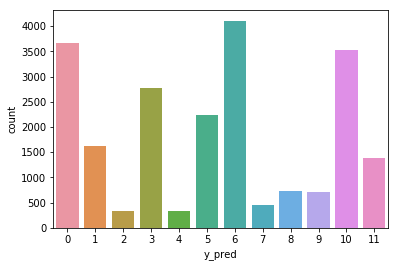

In [44]:
import seaborn as sns
sns.countplot(df.y_pred);

Text(0.5, 0.92, 'Skin color clustering')

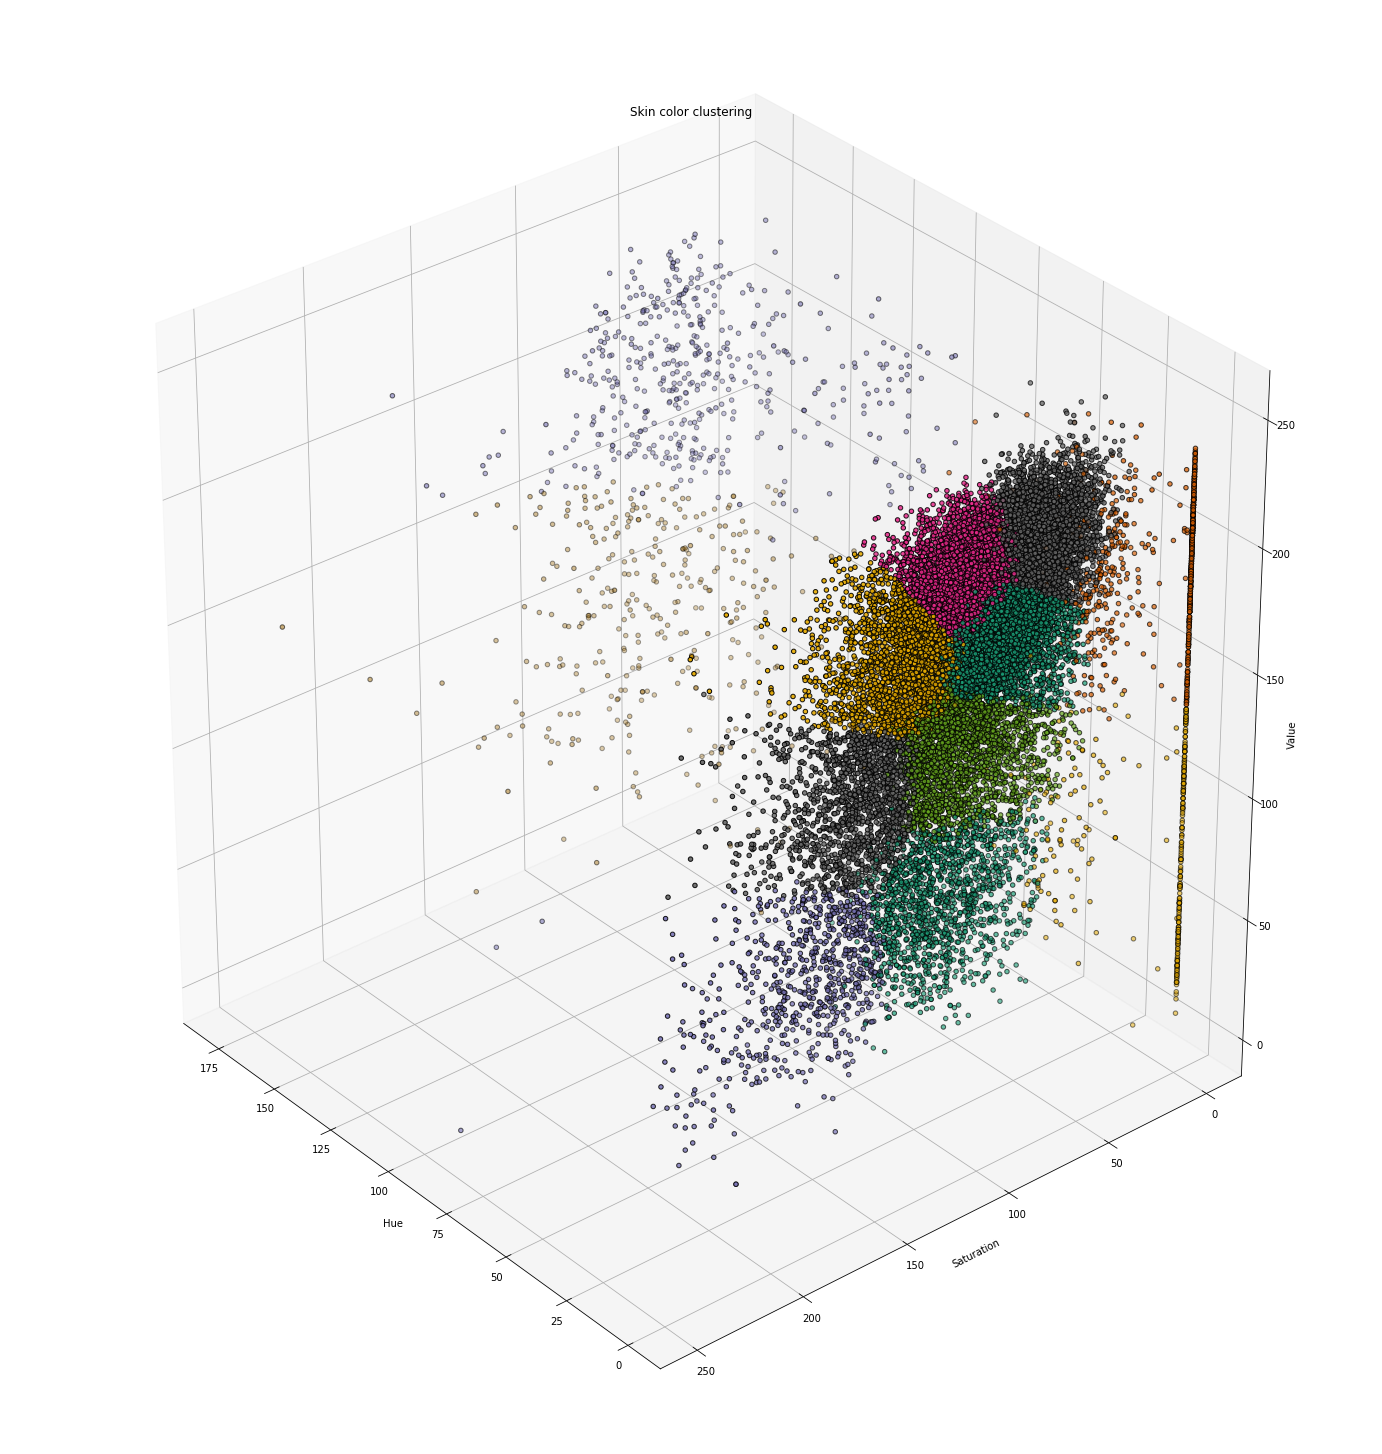

In [45]:
from mpl_toolkits.mplot3d import Axes3D

fig = plt.figure(figsize=(20, 20))
ax = Axes3D(fig, rect=[0, 0, .95, 1], elev=30, azim=140)
labels = kmeans.labels_

ax.scatter(data[:, 0], data[:, 1], data[:, 2],
           c=labels.astype(np.float), edgecolor='k', cmap=plt.cm.get_cmap('Dark2_r'))

ax.set_xlabel('Hue')
ax.set_ylabel('Saturation')
ax.set_zlabel('Value')
ax.set_title('Skin color clustering')


### It can be noted from this 3d plot, that Hue information has very little dispersion with mean value about 15, median = 10, and std = 28. 
### Also, Hue has some outliers, So, I will remove them.



In [73]:
df['H'] = df['H'].astype(np.uint8)
df['S'] = df['S'].astype(np.uint8)
df['V'] = df['V'].astype(np.uint8)

df.describe()

gender           age      etnicity             H             S  \
count  21915.000000  21915.000000  21915.000000  21915.000000  21915.000000   
mean       0.482592     33.272690      1.260370     14.947388     94.457175   
std        0.499708     19.372072      1.352703     28.380193     37.695396   
min        0.000000      1.000000      0.000000      0.000000      0.000000   
25%        0.000000     24.000000      0.000000      7.000000     72.000000   
50%        0.000000     29.000000      1.000000     10.000000     94.000000   
75%        1.000000     45.000000      2.000000     12.000000    117.000000   
max        1.000000    116.000000      4.000000    178.000000    249.000000   

                  V  
count  21915.000000  
mean     180.425279  
std       45.070259  
min        3.000000  
25%      156.000000  
50%      193.000000  
75%      214.000000  
max      251.000000

### Remove outliers and put them in seperate variable


In [74]:
outliers = df[np.abs(df.H-df.H.mean()) >= (2*df.H.std())]
df = df[np.abs(df.H-df.H.mean()) <= (2*df.H.std())]
df = df.reset_index(drop=True)
outliers.shape, df.shape

((799, 9), (21116, 9))

### Note how Hue (H) changed its statistics

In [75]:
df.describe()

gender           age      etnicity             H             S  \
count  21116.000000  21116.000000  21116.000000  21116.000000  21116.000000   
mean       0.485556     33.250852      1.265723      9.542148     95.896429   
std        0.499803     19.292966      1.354622      4.189550     37.084792   
min        0.000000      1.000000      0.000000      0.000000      0.000000   
25%        0.000000     24.000000      0.000000      7.000000     74.000000   
50%        0.000000     29.000000      1.000000      9.000000     95.000000   
75%        1.000000     44.000000      2.000000     12.000000    118.000000   
max        1.000000    116.000000      4.000000     70.000000    241.000000   

                  V  
count  21116.000000  
mean     181.439525  
std       44.441627  
min        3.000000  
25%      158.000000  
50%      194.000000  
75%      215.000000  
max      251.000000

### Train kmeans on clean data again

In [76]:
data = df[['H', 'S', 'V']].values

kmeans = KMeans(n_clusters = 12, n_init = 10, n_jobs=-1)
kmeans.fit(data)
df['y_pred'] = kmeans.labels_

# Add cluster information to df
clt0 = df[df.y_pred == 0]
clt1 = df[df.y_pred == 1]
clt2 = df[df.y_pred == 2]
clt3 = df[df.y_pred == 3]
clt4 = df[df.y_pred == 4]
clt5 = df[df.y_pred == 5]
clt6 = df[df.y_pred == 6]
clt7 = df[df.y_pred == 7]
clt8 = df[df.y_pred == 8]
clt9 = df[df.y_pred == 9]
clt10 = df[df.y_pred == 10]
clt11 = df[df.y_pred == 11]

print('Count occurences for each cluster')
df.y_pred.value_counts()

Count occurences for each cluster


6     3981
1     2925
0     2839
11    2778
4     1885
2     1502
5     1303
10    1150
8     1021
9      800
7      646
3      286
Name: y_pred, dtype: int64

Text(0.5, 0.92, 'Skin color clustering after removing outliers')

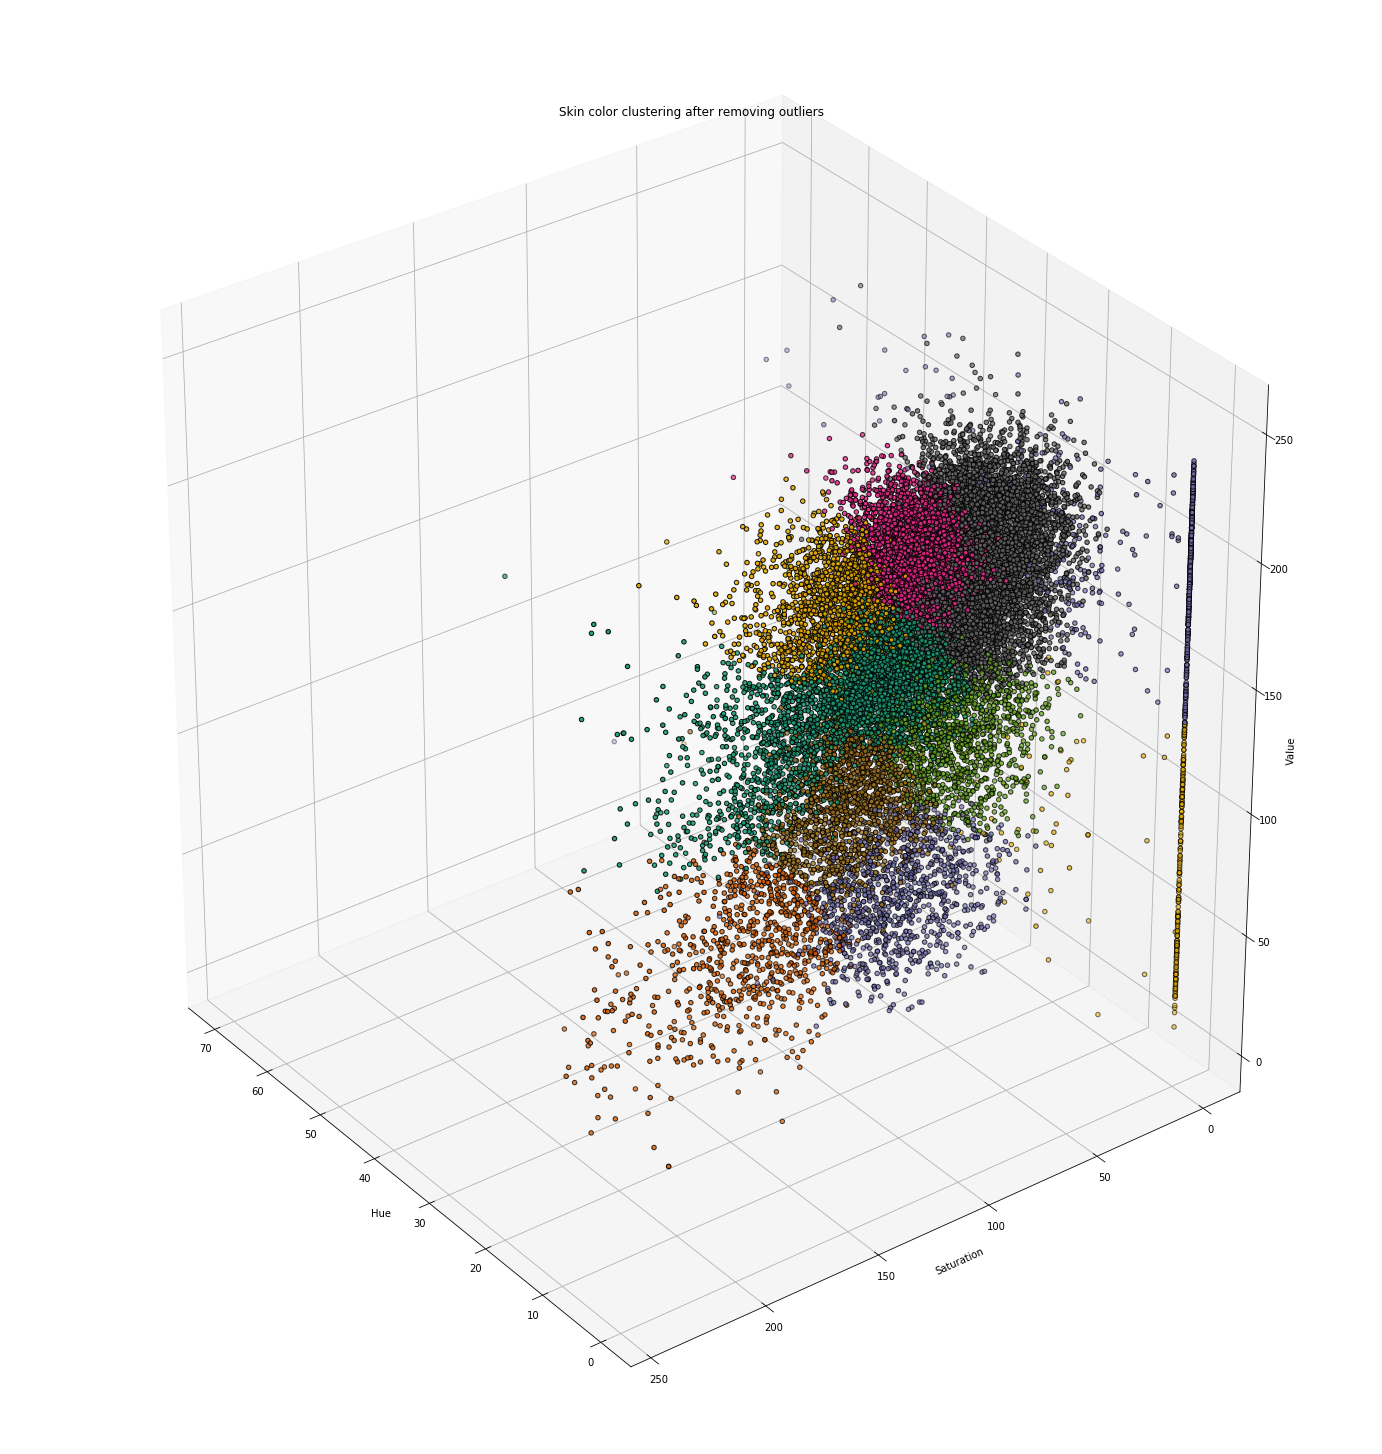

In [77]:
fig = plt.figure(figsize=(20, 20))
ax = Axes3D(fig, rect=[0, 0, .95, 1], elev=30, azim=143)
labels = kmeans.labels_

ax.scatter(data[:, 0], data[:, 1], data[:, 2],
           c=labels.astype(np.float), edgecolor='k', cmap=plt.cm.get_cmap('Dark2_r'))

ax.set_xlabel('Hue')
ax.set_ylabel('Saturation')
ax.set_zlabel('Value')
ax.set_title('Skin color clustering after removing outliers')

### Let's look on images that are at the center of each cluster

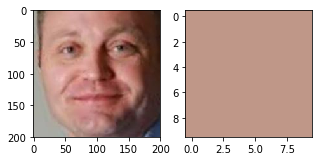

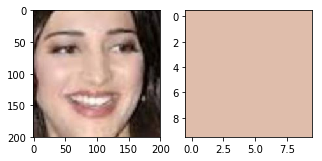

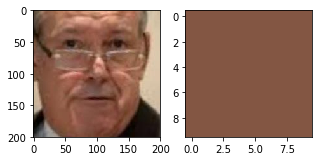

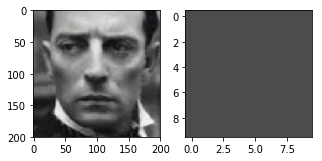

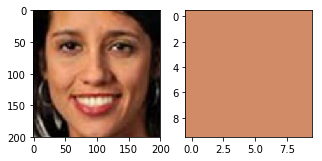

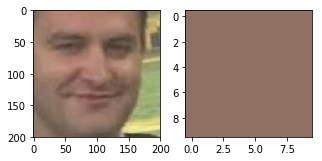

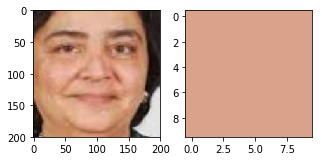

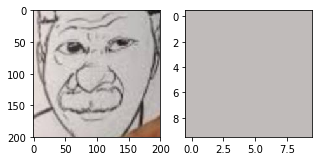

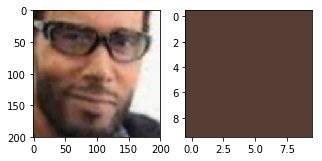

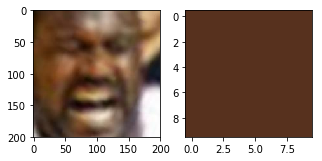

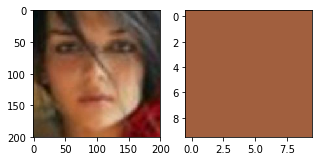

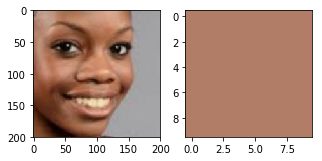

In [78]:
from sklearn.metrics import pairwise_distances_argmin_min
closest, _ = pairwise_distances_argmin_min(kmeans.cluster_centers_, data)
closest
for num, i in enumerate(closest):
    img = cv2.imread(path + df.at[i, 'path'])

    color_rgb = cv2.cvtColor(np.uint8([[kmeans.cluster_centers_[num]]]), cv2.COLOR_HSV2RGB)

    lo_square = np.full((10, 10, 3), color_rgb, dtype=np.uint8)
    f, (ax1, ax2) = plt.subplots(1, 2, figsize=(5, 5))

    ax1.imshow(img[:,:,[2,1,0]])
    ax2.imshow(lo_square)
    plt.show()

### Now, let's look on the images of each cluster

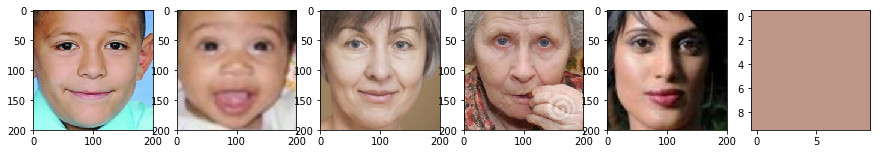

In [96]:
from itertools import zip_longest

def show_batch(i1, i2, i3, i4, i5, path, df, cluster_num):
    color_rgb = cv2.cvtColor(np.uint8([[kmeans.cluster_centers_[cluster_num]]]), cv2.COLOR_HSV2RGB)
    lo_square = np.full((10, 10, 3), color_rgb, dtype=np.uint8)
    
    img1 = cv2.imread(path + df.at[i1, 'path'])
    img2 = cv2.imread(path + df.at[i2, 'path'])
    img3 = cv2.imread(path + df.at[i3, 'path'])
    img4 = cv2.imread(path + df.at[i4, 'path'])
    img5 = cv2.imread(path + df.at[i5, 'path'])
    
    f, (ax1, ax2, ax3, ax4, ax5, ax6) = plt.subplots(1, 6, figsize=(15, 5))

    ax1.imshow(img1[:,:,[2,1,0]])
    ax2.imshow(img2[:,:,[2,1,0]])
    ax3.imshow(img3[:,:,[2,1,0]])
    ax4.imshow(img4[:,:,[2,1,0]])
    ax5.imshow(img5[:,:,[2,1,0]])
    ax6.imshow(lo_square)

    plt.show()

def grouper(n, iterable, fillvalue=None):
    "grouper(3, 'ABCDEFG', 'x') --> ABC DEF Gxx"
    args = [iter(iterable)] * n
    return zip_longest(fillvalue=fillvalue, *args)

for i1, i2, i3, i4, i5 in grouper(5, clt0.index[:5]):
    show_batch(i1, i2, i3, i4, i5, path, df, 0)

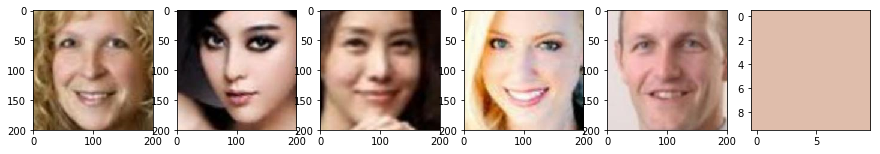

In [97]:
for i1, i2, i3, i4, i5 in grouper(5, clt1.index[:5]):
    show_batch(i1, i2, i3, i4, i5, path, df, 1)

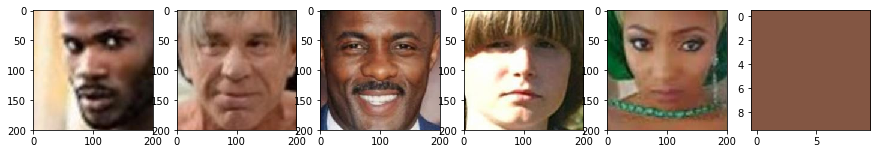

In [98]:
for i1, i2, i3, i4, i5 in grouper(5, clt2.index[:5]):
    show_batch(i1, i2, i3, i4, i5, path, df, 2)

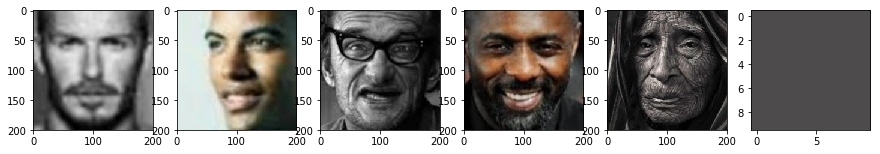

In [99]:
for i1, i2, i3, i4, i5 in grouper(5, clt3.index[:5]):
    show_batch(i1, i2, i3, i4, i5, path, df, 3)

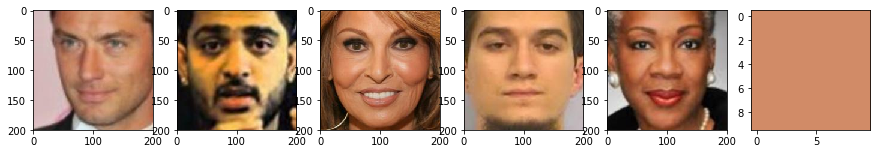

In [100]:
for i1, i2, i3, i4, i5 in grouper(5, clt4.index[:5]):
    show_batch(i1, i2, i3, i4, i5, path, df, 4)

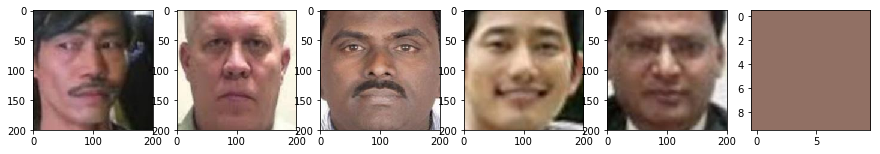

In [101]:
for i1, i2, i3, i4, i5 in grouper(5, clt5.index[:5]):
    show_batch(i1, i2, i3, i4, i5, path, df, 5)

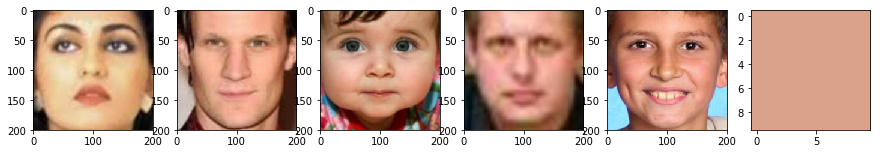

In [103]:
for i1, i2, i3, i4, i5 in grouper(5, clt6.index[:5]):
    show_batch(i1, i2, i3, i4, i5, path, df, 6)

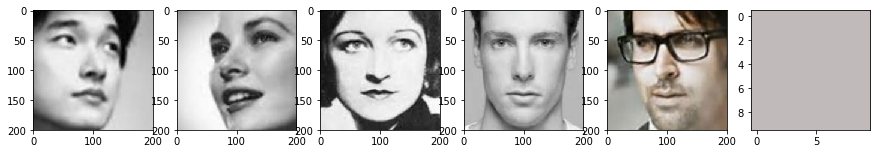

In [104]:
for i1, i2, i3, i4, i5 in grouper(5, clt7.index[:5]):
    show_batch(i1, i2, i3, i4, i5, path, df, 7)

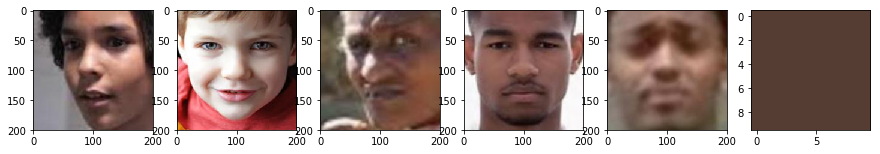

In [105]:
for i1, i2, i3, i4, i5 in grouper(5, clt8.index[:5]):
    show_batch(i1, i2, i3, i4, i5, path, df, 8)

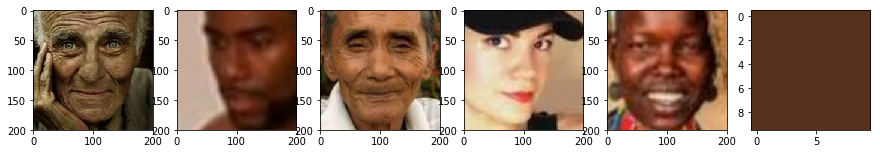

In [106]:
for i1, i2, i3, i4, i5 in grouper(5, clt9.index[:5]):
    show_batch(i1, i2, i3, i4, i5, path, df, 9)

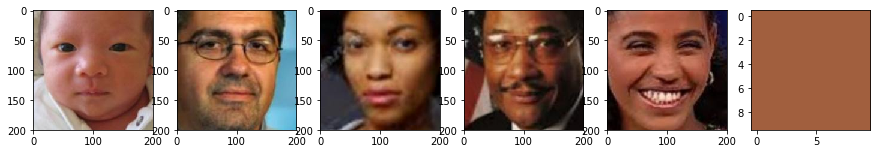

In [107]:
for i1, i2, i3, i4, i5 in grouper(5, clt10.index[:5]):
    show_batch(i1, i2, i3, i4, i5, path, df, 10)

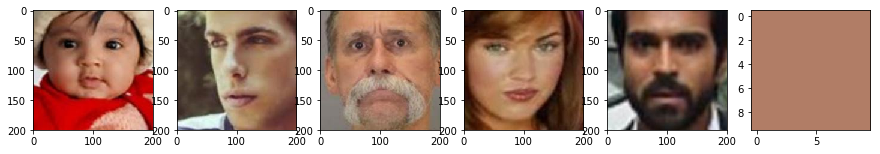

In [108]:
for i1, i2, i3, i4, i5 in grouper(5, clt11.index[:5]):
    show_batch(i1, i2, i3, i4, i5, path, df, 11)

## Conclusions

### Clustering algorithms work satisfactory and is able to give meaningful results, it differentiats the tones of the skin on 12 different clusters of the different hue and tonalities. 

### Color detection scheme is robust enough. But because of the different lighting conditions on the pictures it sometimes can give mistakes. For example, if the white face in the shadow the algorithms would find it blackish. In the opposite, if the black face would reflect too much light, it would be considered as whitish.